# Load data

In [59]:
from utils import read_EHG, read_EMR
emr = read_EMR.read_EMR('dataset')
ehg = read_EHG.read_EHG('dataset')

g:\Sinh_non\Sinh_non\utils\read_EMR.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bleeding_first_trimester']=df['Bleeding_first_trimester'].replace({'yes':1,'no':0})
g:\Sinh_non\Sinh_non\utils\read_EMR.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bleeding_second_trimester']=df['Bleeding_second_trimester'].replace({'yes':1,'no':0})
g:\Sinh_non\Sinh_non\utils\read_EMR.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, expli

In [60]:
import numpy as np
X_ehg = np.array(ehg[-1])
X_emr = np.array(emr[1])
y_binary = np.array(ehg[0])[:, 0]
y_regression = np.array(ehg[0])[:, 1].reshape(-1, 1)

# Utils

In [61]:
import matplotlib.pyplot as plt

def visualize(history):
    plt.figure(figsize=(20,12))
    # Accuracy
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2,2,2)
    plt.plot(history.history['precision'], label='Train Prec')
    plt.plot(history.history['val_precision'], label='Val Prec')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2,2,3)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def visualize2(history):
    plt.figure(figsize=(20,12))
    # Accuracy
    plt.subplot(2,2,1)
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Val MSE')
    plt.title('MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # Precision
    plt.subplot(2,2,2)
    plt.plot(history.history['mae'], label='Train Mae')
    plt.plot(history.history['val_mae'], label='Val Mae')
    plt.title('MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Binary classification

## Split data

In [62]:
import keras

from sklearn.model_selection import train_test_split
y_binary = keras.utils.to_categorical(y_binary, num_classes=2)

X_ehg_train, X_ehg_test, y_ehg_train, y_ehg_test = train_test_split(X_ehg, y_binary, test_size=0.2, random_state=42)
X_emr_train, X_emr_test, y_emr_train, y_emr_test = train_test_split(X_emr, y_binary, test_size=0.2, random_state=42)


In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_emr_train = scaler.fit_transform(X_emr_train)
X_emr_test = scaler.transform(X_emr_test)

## TCN: temporal convolution neural

In [64]:
from keras import layers, Model


class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, dilation_rate=1, dropout=0.0, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout

        # conv layers (causal padding)
        self.conv1 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.drop1 = layers.Dropout(dropout) if dropout > 0 else None

        self.conv2 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.drop2 = layers.Dropout(dropout) if dropout > 0 else None

        # residual add + final activation
        self.add_layer = layers.Add()
        self.final_act = layers.ReLU()

        # downsample will be created in build() only if needed
        self.downsample = None

    def build(self, input_shape):
        # input_shape: (batch, time, channels_in)
        channels_in = int(input_shape[-1])
        if channels_in != self.filters:
            # create 1x1 conv to match channels
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding="same", use_bias=False)
        else:
            # identity function (lambda)
            self.downsample = lambda x: x
        super().build(input_shape)

    def call(self, x, training=None):
        y = self.conv1(x)
        y = self.bn1(y, training=training)
        y = self.act1(y)
        if self.drop1 is not None:
            y = self.drop1(y, training=training)

        y = self.conv2(y)
        y = self.bn2(y, training=training)
        y = self.act2(y)
        if self.drop2 is not None:
            y = self.drop2(y, training=training)

        # residual path: downsample(x) if needed, else identity
        res = self.downsample(x)  # either a Layer or a lambda identity

        out = self.add_layer([res, y])
        return self.final_act(out)


class MultiInputModelTCN(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # TCN branch for time series
        self.tcn1 = TCNBlock(filters=8, kernel_size=3, dilation_rate=1, dropout=0.1)
        self.tcn2 = TCNBlock(filters=16, kernel_size=3, dilation_rate=2, dropout=0.1)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.ts_dense = layers.Dense(16, activation="relu")

        # Tabular branch (MLP)
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # Combined MLP
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # TCN branch
        x1 = self.tcn1(ts_input, training=training)
        x1 = self.tcn2(x1, training=training)
        x1 = self.global_pool(x1)   # -> (batch, channels)
        x1 = self.ts_dense(x1)

        # Tabular branch
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # Combine
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
    def build(self, input_shape):
        super().build(input_shape)


In [65]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, Callback

# Hàm scheduler
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.6
    return lr

# Callback để log lr mỗi epoch
class LrLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr_obj = self.model.optimizer.learning_rate
        if hasattr(lr_obj, 'numpy'):
            lr = float(lr_obj.numpy())
        else:
            lr = float(tf.keras.backend.get_value(lr_obj))
        print(f"Epoch {epoch+1}: lr = {lr:.6f}")

lr_callback = LearningRateScheduler(scheduler, verbose=1)
log_callback = LrLogger()

In [66]:
model = MultiInputModelTCN(num_classes=2)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", "precision", "recall"])

In [67]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    callbacks=[lr_callback, log_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.2812 - loss: 1.0749 - precision: 0.2812 - recall: 0.2812Epoch 1: lr = 0.001000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.3858 - loss: 0.9188 - precision: 0.3858 - recall: 0.3858 - val_accuracy: 0.6875 - val_loss: 0.6586 - val_precision: 0.6875 - val_recall: 0.6875 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7500 - loss: 0.6377 - precision: 0.7500 - recall: 0.7500Epoch 2: lr = 0.001000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8189 - loss: 0.5226 - precision: 0.8189 - recall: 0.8189 - val_accuracy: 0.7500 - val_loss: 0.6703 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
1/4 ━━━━━━━━━━━━━━━━━━

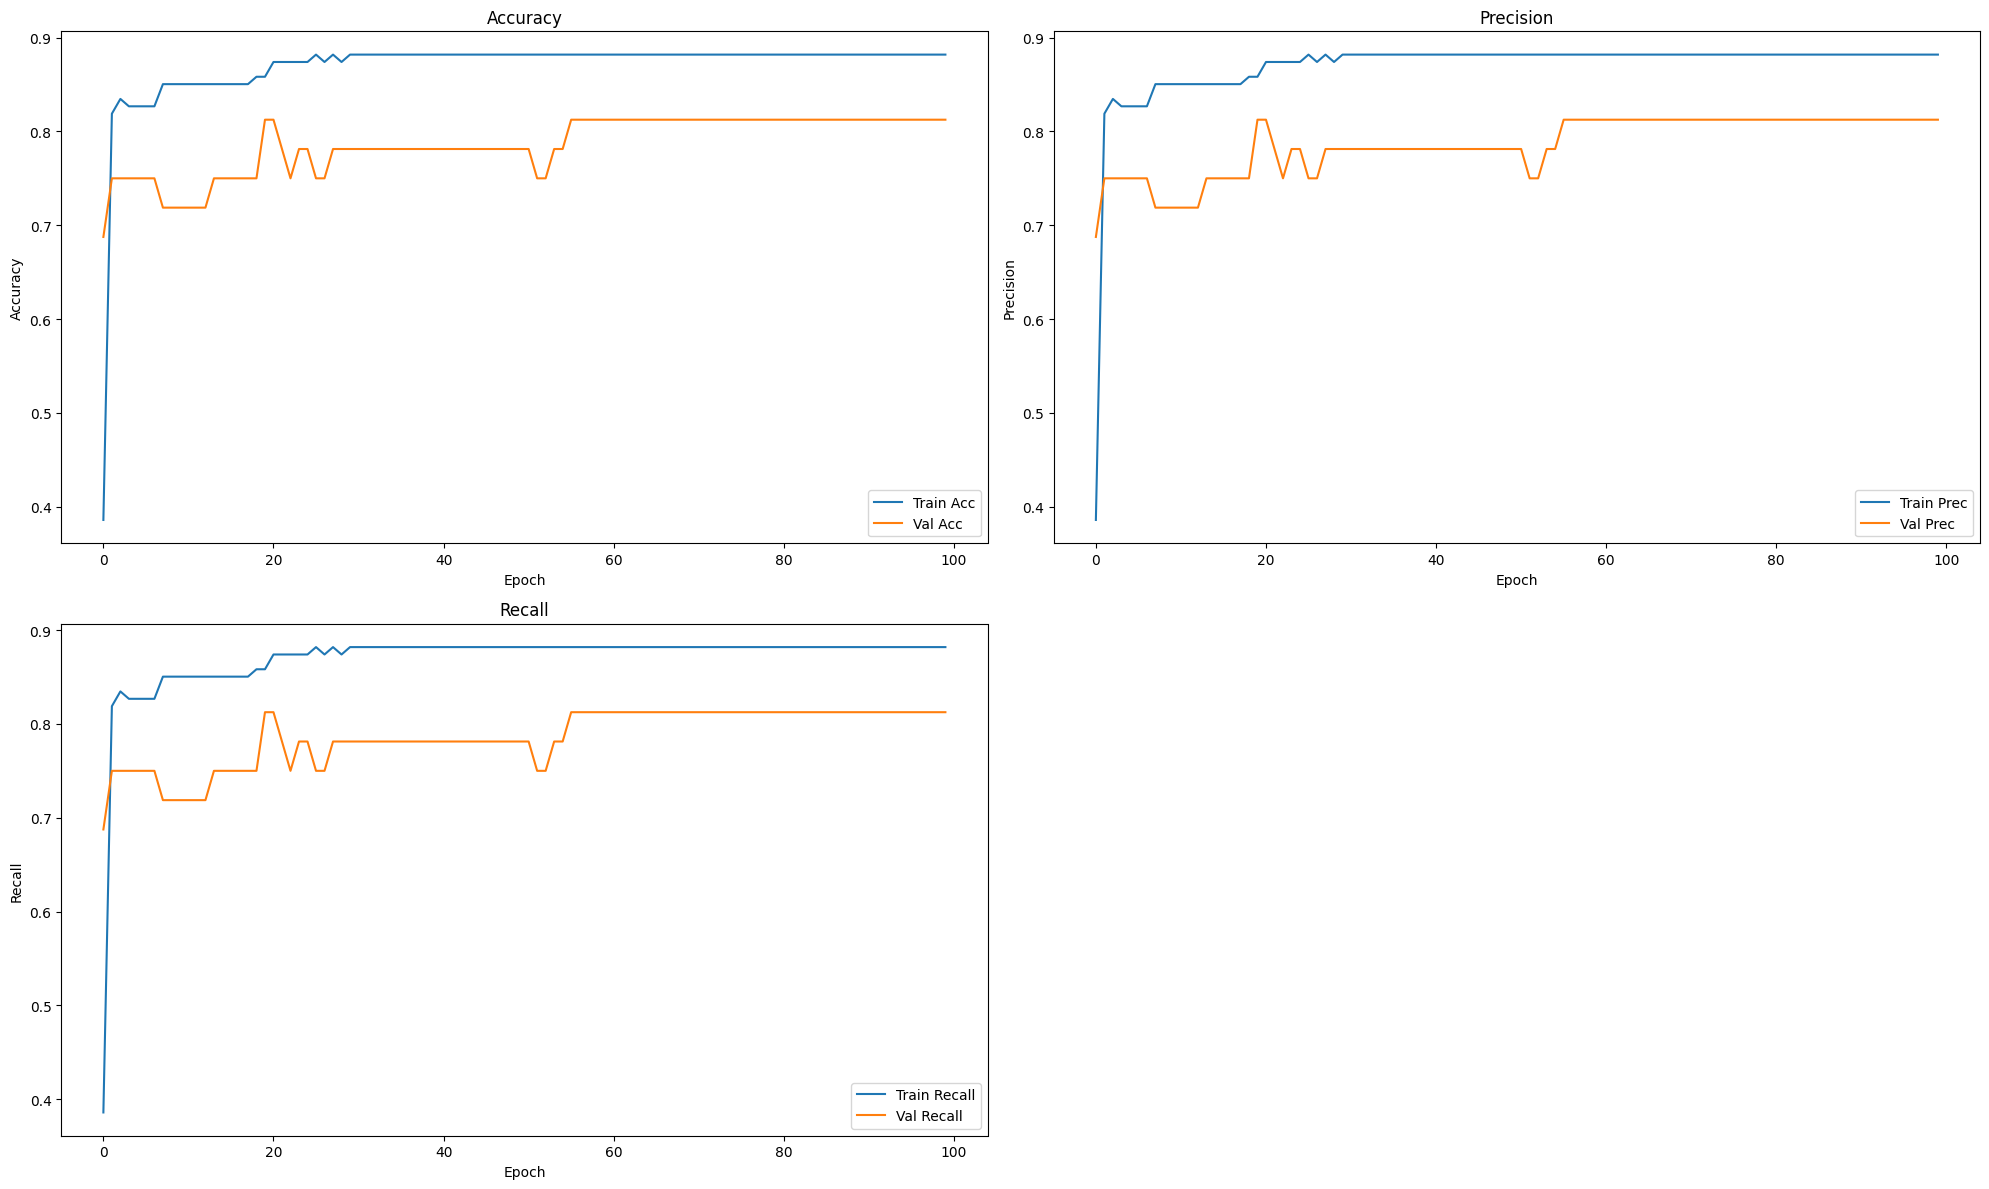

In [68]:
visualize(history= history)

## biLSTM

In [69]:
from keras import layers, Model
class BiLSTMBlock(layers.Layer):
    def __init__(self, units, dropout=0.0, return_sequences=True, name=None):
        super().__init__(name=name)
        self.units = units
        self.dropout_rate = dropout
        self.return_sequences = return_sequences

        # Bidirectional wrapper
        self.bilstm = layers.Bidirectional(
            layers.LSTM(units, dropout=dropout, return_sequences=return_sequences)
        )
        self.act = layers.ReLU()

    def call(self, x, training=None):
        y = self.bilstm(x, training=training)
        y = self.act(y)
        return y


class MultiInputModelLSTM(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # ======== BiLSTM branch for time series ========
        self.bilstm1 = BiLSTMBlock(units=32, dropout=0.1, return_sequences=True)
        self.bilstm2 = BiLSTMBlock(units=16, dropout=0.2, return_sequences=False)
        self.ts_dense = layers.Dense(16, activation="relu")

        # ======== Tabular branch (MLP) ========
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # ======== Combined MLP ========
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # --- Time series branch (BiLSTM) ---
        x1 = self.bilstm1(ts_input, training=training)
        x1 = self.bilstm2(x1, training=training)
        x1 = self.ts_dense(x1)

        # --- Tabular branch ---
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # --- Combine two branches ---
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)

    def build(self, input_shape):
        super().build(input_shape)


In [70]:
model = MultiInputModelLSTM(num_classes=2)
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy", "precision", 'recall'])

In [71]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    callbacks=[lr_callback, log_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3003 - loss: 0.7150 - precision: 0.3045 - recall: 0.3003Epoch 1: lr = 0.001000
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 406ms/step - accuracy: 0.4252 - loss: 0.7161 - precision: 0.4286 - recall: 0.4252 - val_accuracy: 0.5938 - val_loss: 0.7050 - val_precision: 0.5938 - val_recall: 0.5938 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7247 - loss: 0.6881 - precision: 0.7247 - recall: 0.7247Epoch 2: lr = 0.001000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7165 - loss: 0.6873 - precision: 0.7165 - recall: 0.7165 - val_accuracy: 0.6562 - val_loss: 0.6827 - val_precision: 0.6562 - val_recall: 0.6562 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━

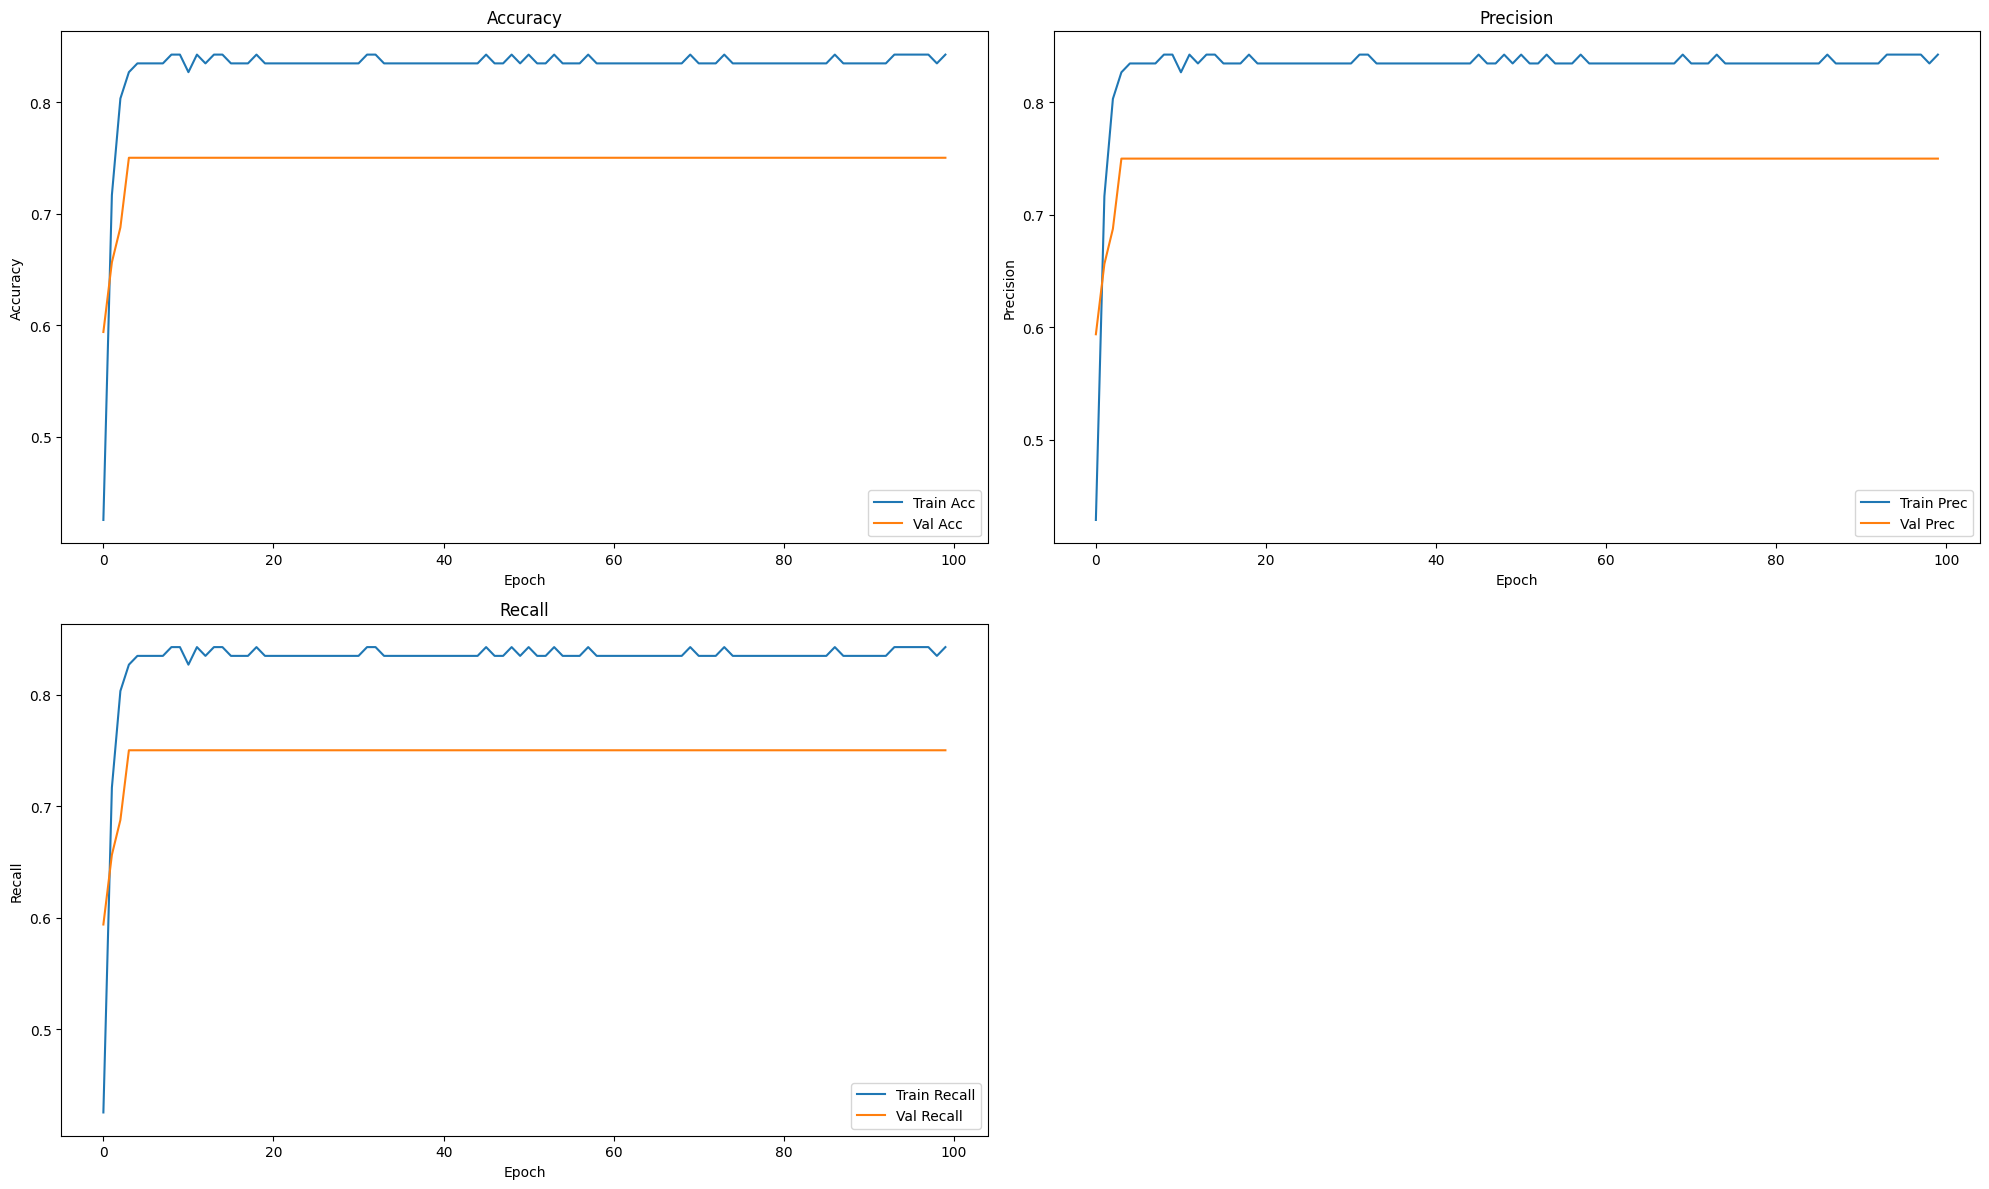

In [72]:
visualize(history= history)

## regression

In [73]:
from sklearn.model_selection import train_test_split

X_ehg_train, X_ehg_test, y_ehg_train, y_ehg_test = train_test_split(X_ehg, y_regression, test_size=0.2, random_state=42)
X_emr_train, X_emr_test, y_emr_train, y_emr_test = train_test_split(X_emr, y_regression, test_size=0.2, random_state=42)

In [74]:
from keras import layers, Model


class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, dilation_rate=1, dropout=0.0, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout

        # conv layers (causal padding)
        self.conv1 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.drop1 = layers.Dropout(dropout) if dropout > 0 else None

        self.conv2 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.drop2 = layers.Dropout(dropout) if dropout > 0 else None

        # residual add + final activation
        self.add_layer = layers.Add()
        self.final_act = layers.ReLU()

        # downsample will be created in build() only if needed
        self.downsample = None

    def build(self, input_shape):
        # input_shape: (batch, time, channels_in)
        channels_in = int(input_shape[-1])
        if channels_in != self.filters:
            # create 1x1 conv to match channels
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding="same", use_bias=False)
        else:
            # identity function (lambda)
            self.downsample = lambda x: x
        super().build(input_shape)

    def call(self, x, training=None):
        y = self.conv1(x)
        y = self.bn1(y, training=training)
        y = self.act1(y)
        if self.drop1 is not None:
            y = self.drop1(y, training=training)

        y = self.conv2(y)
        y = self.bn2(y, training=training)
        y = self.act2(y)
        if self.drop2 is not None:
            y = self.drop2(y, training=training)

        # residual path: downsample(x) if needed, else identity
        res = self.downsample(x)  # either a Layer or a lambda identity

        out = self.add_layer([res, y])
        return self.final_act(out)


class MultiInputModelTCN(Model):
    def __init__(self):
        super().__init__()

        # TCN branch for time series
        self.tcn1 = TCNBlock(filters=8, kernel_size=3, dilation_rate=1, dropout=0.1)
        self.tcn2 = TCNBlock(filters=16, kernel_size=3, dilation_rate=2, dropout=0.1)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.ts_dense = layers.Dense(16, activation="relu")

        # Tabular branch (MLP)
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # Combined MLP
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(1, activation=None)

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # TCN branch
        x1 = self.tcn1(ts_input, training=training)
        x1 = self.tcn2(x1, training=training)
        x1 = self.global_pool(x1)   # -> (batch, channels)
        x1 = self.ts_dense(x1)

        # Tabular branch
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # Combine
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
    
    def build(self, input_shape):
        super().build(input_shape)


In [75]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, Callback

# Hàm scheduler
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.8
    return lr

# Callback để log lr mỗi epoch
class LrLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr_obj = self.model.optimizer.learning_rate
        if hasattr(lr_obj, 'numpy'):
            lr = float(lr_obj.numpy())
        else:
            lr = float(tf.keras.backend.get_value(lr_obj))
        print(f"Epoch {epoch+1}: lr = {lr:.6f}")

lr_callback = LearningRateScheduler(scheduler, verbose=1)
log_callback = LrLogger()

In [76]:
model = MultiInputModelTCN()
model.compile(
    optimizer= keras.optimizers.Adam(0.01),
    loss="mse",        
    metrics=["mae", "mse"]
)

In [77]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    callbacks=[lr_callback, log_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 75754.0312 - mae: 275.0049 - mse: 75754.0312Epoch 1: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 67282.0234 - mae: 258.5864 - mse: 67282.0234 - val_loss: 53490.1953 - val_mae: 230.5880 - val_mse: 53490.1953 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 54319.4766 - mae: 232.3043 - mse: 54319.4766Epoch 2: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 44726.6289 - mae: 209.9268 - mse: 44726.6289 - val_loss: 24624.9492 - val_mae: 154.9716 - val_mse: 24624.9492 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 24600.1836 - mae: 153.7427 - mse: 24600.1836Epoch 3: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27

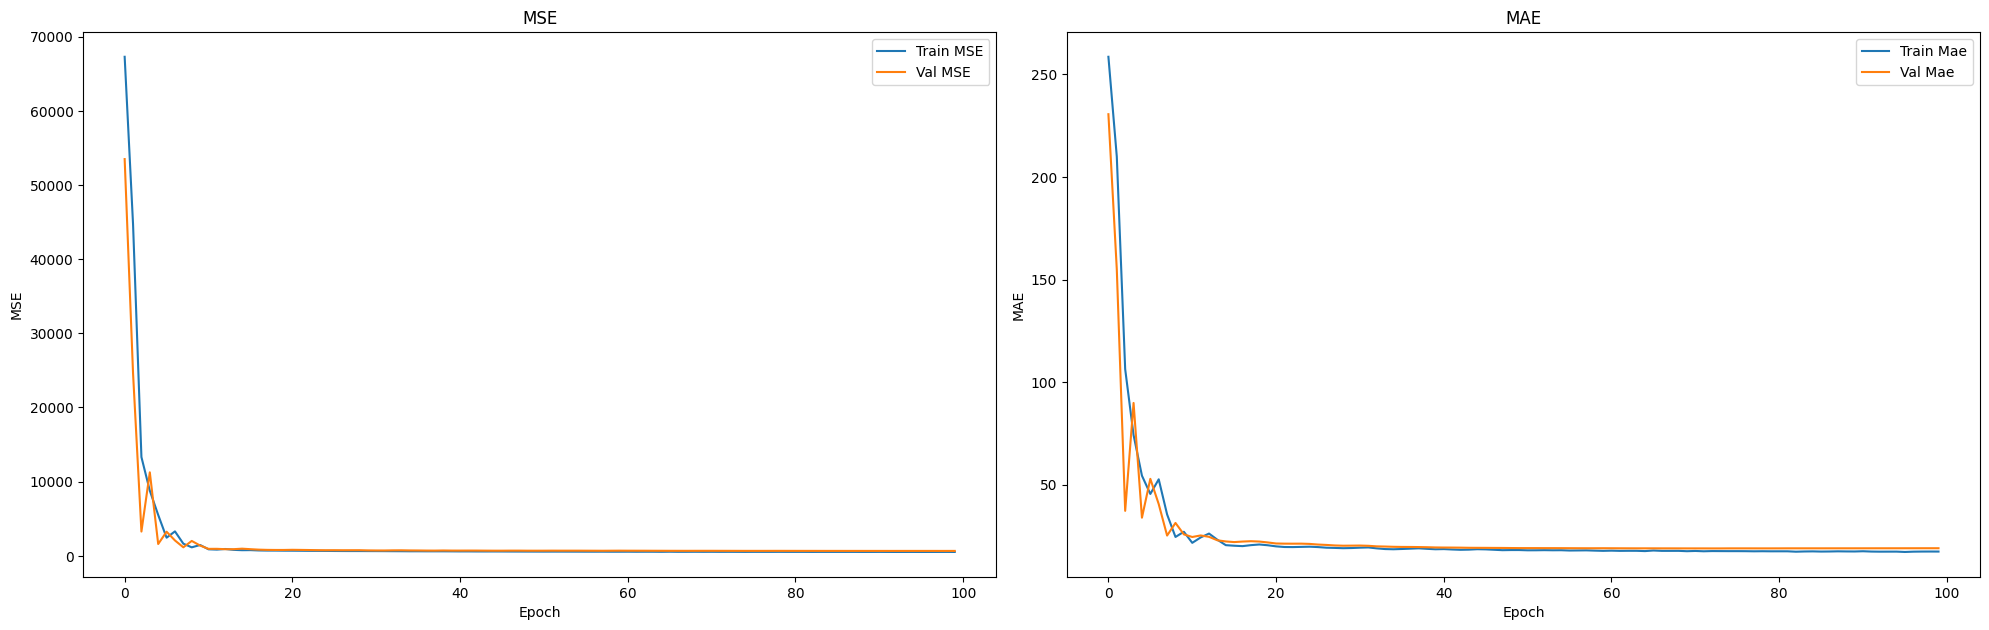

In [78]:
visualize2(history= history)

## LSTM

In [79]:
from keras import layers, Model
class BiLSTMBlock(layers.Layer):
    def __init__(self, units, dropout=0.0, return_sequences=True, name=None):
        super().__init__(name=name)
        self.units = units
        self.dropout_rate = dropout
        self.return_sequences = return_sequences

        # Bidirectional wrapper
        self.bilstm = layers.Bidirectional(
            layers.LSTM(units, dropout=dropout, return_sequences=return_sequences)
        )
        self.act = layers.ReLU()

    def call(self, x, training=None):
        y = self.bilstm(x, training=training)
        y = self.act(y)
        return y


class MultiInputModelLSTM(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # ======== BiLSTM branch for time series ========
        self.bilstm1 = BiLSTMBlock(units=32, dropout=0.1, return_sequences=True)
        self.bilstm2 = BiLSTMBlock(units=16, dropout=0.2, return_sequences=False)
        self.ts_dense = layers.Dense(16, activation="relu")

        # ======== Tabular branch (MLP) ========
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # ======== Combined MLP ========
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(1, activation=None)

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # --- Time series branch (BiLSTM) ---
        x1 = self.bilstm1(ts_input, training=training)
        x1 = self.bilstm2(x1, training=training)
        x1 = self.ts_dense(x1)

        # --- Tabular branch ---
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # --- Combine two branches ---
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)

    def build(self, input_shape):
        super().build(input_shape)


In [80]:
model = MultiInputModelLSTM(1)
model.compile(
    optimizer= keras.optimizers.Adam(0.01),
    loss="mse",        
    metrics=["mae", "mse"]
)

In [81]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    callbacks=[lr_callback, log_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 68869.2109 - mae: 261.7479 - mse: 68869.2109Epoch 1: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 67483.4688 - mae: 259.1675 - mse: 67483.4688 - val_loss: 56755.4844 - val_mae: 237.6170 - val_mse: 56755.4844 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 52926.0391 - mae: 229.0399 - mse: 52926.0391Epoch 2: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 48331.9727 - mae: 218.5051 - mse: 48331.9727 - val_loss: 28047.3320 - val_mae: 166.3856 - val_mse: 28047.3320 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 22644.5195 - mae: 145.2136 - mse: 22644.5195Epoch 3: lr = 0.010000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

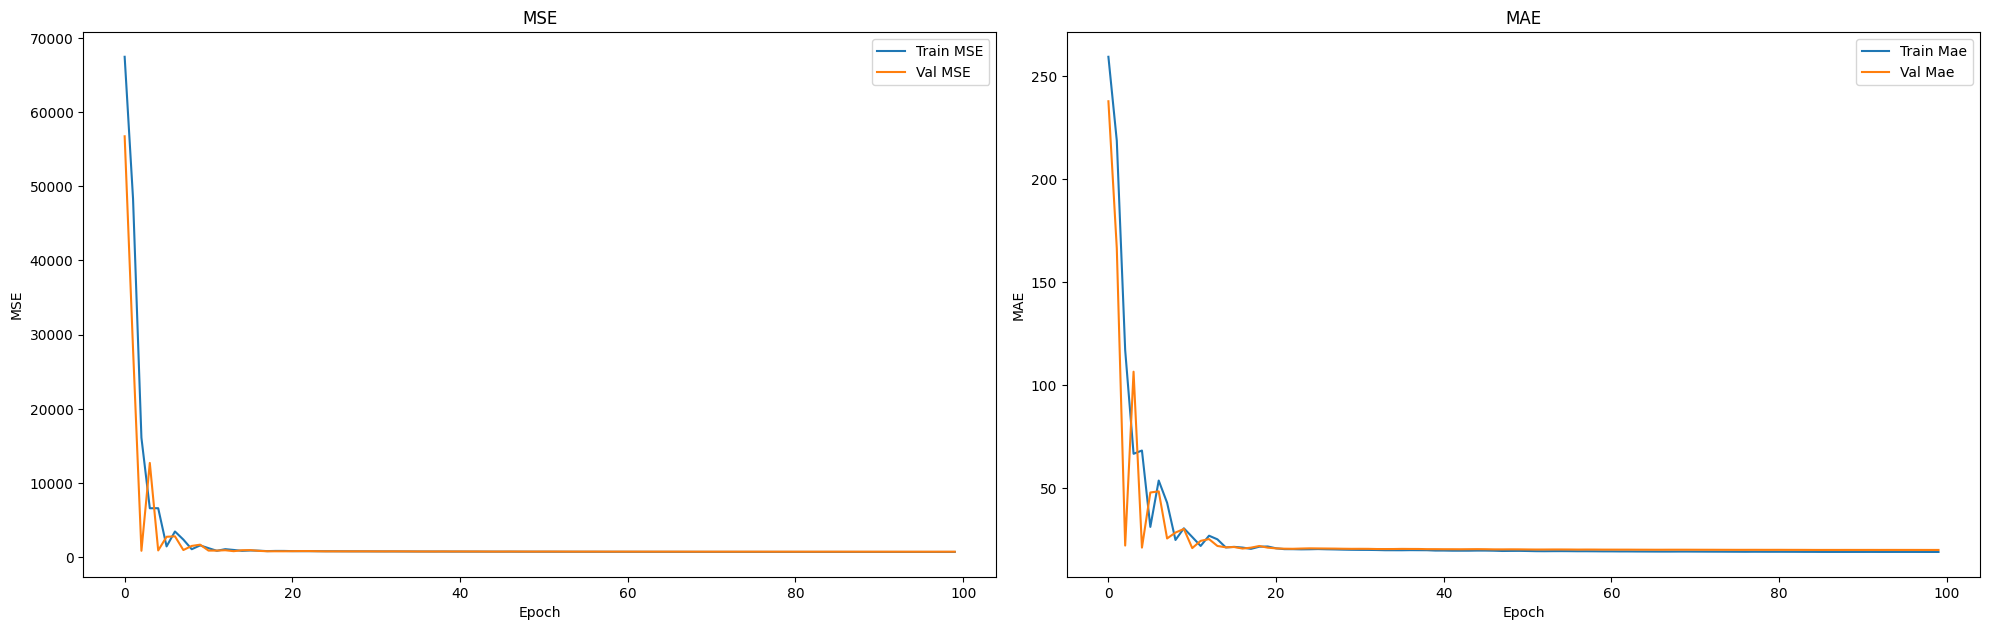

In [82]:
visualize2(history= history)